In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymysql
from sklearn.preprocessing import LabelEncoder

## 取得資料

In [3]:
def get_data(table):
    config = {"host" : "mqtt2.tibame.cloud", "port" : 3306, "user" : "hsuan",
          "passwd" : "hsuan", "db" : "Disease", "charset" : "utf8mb4"}

    conn = pymysql.connect(**config) ## **會將字典型態轉變(kwargs)
    cursor = conn.cursor()
    
    SQL = "select * from {}".format(table)
    print('資料筆數 :',cursor.execute(SQL))
    
    results = cursor.fetchall()
    data = pd.DataFrame(results, columns = ["ID", "type", "year", "age", "county", "week", "case"])
    data = data.drop("ID", axis=1)
    
    # 關閉連線
    cursor.close()
    conn.close()
    
    return data

In [4]:
df = get_data("enterovirus")
df.head()

資料筆數 : 7167


,type,year,age,county,week,case
0,住院,2008,0-2,桃園市,14,0
1,住院,2008,10-14,桃園市,14,0
2,住院,2008,15+,桃園市,14,0
3,住院,2008,3-4,桃園市,14,0
4,住院,2008,5-9,桃園市,14,0


## LabelEncoder
> 1. 0 ~ 2 歲：0
> 2. 10 ~ 14 歲：1
> 3. 15 歲以上：2
> 4. 3 ~ 4 歲：3
> 5. 5 ~ 9 歲：4

In [6]:
Label_Encoder = LabelEncoder()
df["new_age"] = Label_Encoder.fit_transform(df['age'])
df.head(10)

,type,year,age,county,week,case,new_age
0,住院,2008,0-2,桃園市,14,0,0
1,住院,2008,10-14,桃園市,14,0,1
2,住院,2008,15+,桃園市,14,0,2
3,住院,2008,3-4,桃園市,14,0,3
4,住院,2008,5-9,桃園市,14,0,4
5,門診,2008,0-2,桃園市,14,60,0
6,門診,2008,10-14,桃園市,14,6,1
7,門診,2008,15+,桃園市,14,23,2
8,門診,2008,3-4,桃園市,14,55,3
9,門診,2008,5-9,桃園市,14,85,4


In [7]:
### 不區 type (住院、門診)
df1 = df.groupby(["year","week", "new_age"], as_index=False).sum()
df1.week = df1.week.astype(int)
df1["new_age"] = df1["new_age"].astype(str)
df1.sort_values(by = ["year","week"])

,year,week,new_age,case
0,2008,14,0,60
1,2008,14,1,6
2,2008,14,2,23
3,2008,14,3,55
4,2008,14,4,85
...,...,...,...,...
3560,2021,50,0,3
3561,2021,50,1,0
3562,2021,50,2,0
3563,2021,50,3,1


In [8]:
df2 = df1[df1.year == "2021"].set_index("week").sort_index()
df2.head()

,year,new_age,case
week,,,
1,2021,0,127
1,2021,1,33
1,2021,2,35
1,2021,3,127
1,2021,4,221


In [10]:
age_0_2 = df2[df2["new_age"] == "0"]
age_10_14 = df2[df2["new_age"] == "1"]
age_15 = df2[df2["new_age"] == "2"]
age_3_4 = df2[df2["new_age"] == "3"]
age_5_9 = df2[df2["new_age"] == "4"]

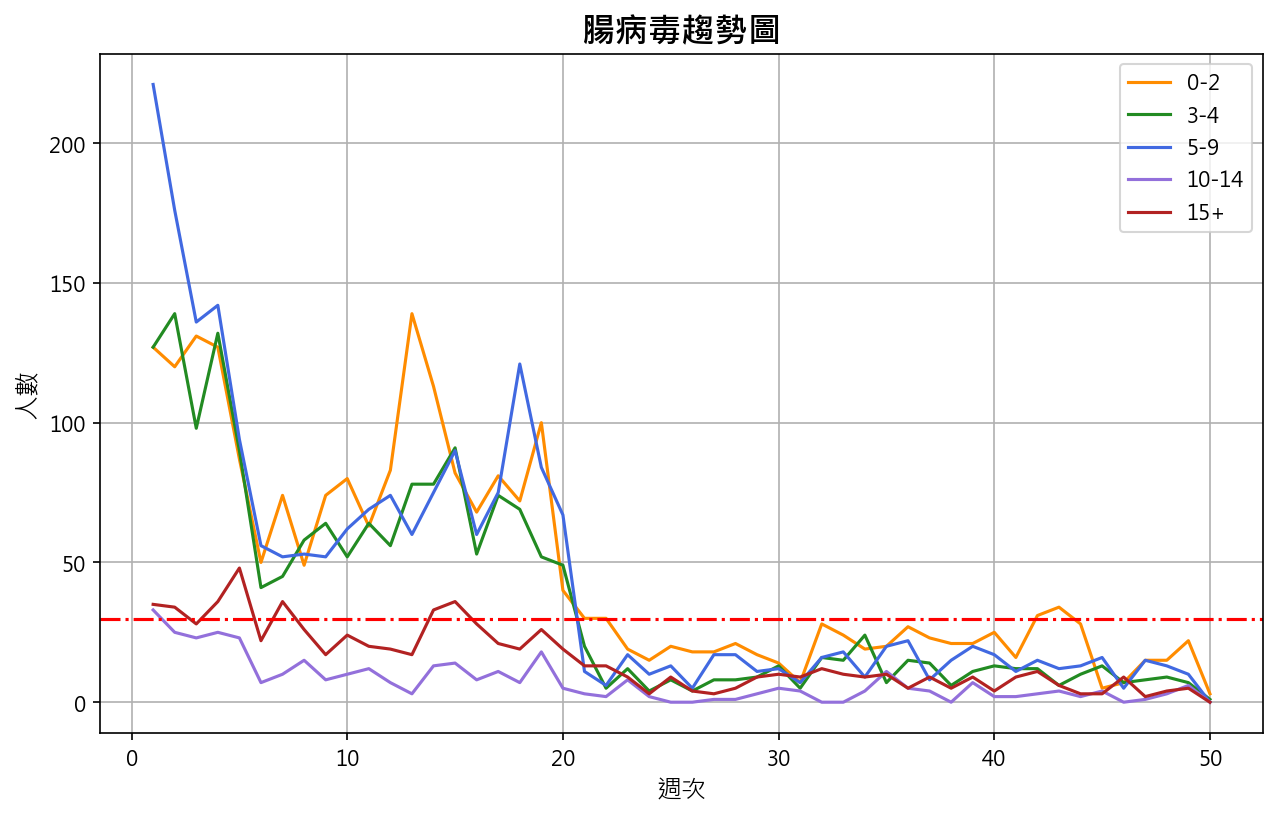

In [12]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定字體
plt.rcParams['axes.unicode_minus'] = False                # 用來正常顯示負號
plt.rcParams["figure.figsize"] = (10,6)
plt.figure(dpi=150)
plt.plot(age_0_2["case"], label = "0-2", color = "darkorange")
plt.plot(age_3_4["case"], label = "3-4", color = "forestgreen")
plt.plot(age_5_9["case"], label = "5-9", color = "royalblue")
plt.plot(age_10_14["case"], label = "10-14", color = "mediumpurple")
plt.plot(age_15["case"], label = "15+", color = "firebrick") #linestyle='-', marker = "o"
plt.axhline(y=df2["case"].mean(), color = 'red', linestyle='-.')
plt.xlabel("週次", fontsize=12)                # 設定 x 軸標題及粗體
plt.ylabel("人數", fontsize=12)  # 設定 y 軸標題及粗體
plt.title("腸病毒趨勢圖", fontsize = 16, fontweight = "bold")   # 設定標題、文字大小、粗體及位置
plt.legend(loc='best')
plt.grid()
plt.show()